In [1]:
import torch
import numpy as np
import cv2
import signatory
import matplotlib.pyplot as plt
from collections import Counter

train_img_1's shape is (512, 512).
tumor_mask_1's shape is (512, 512).
train_img_2's shape is (512, 512).
tumor_mask_2's shape is (512, 512).
train_img_3's shape is (512, 512).
tumor_mask_3's shape is (512, 512).


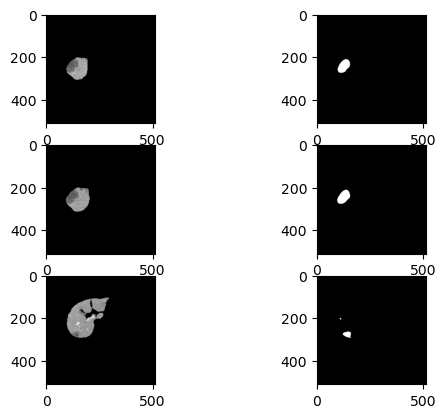

In [2]:
# 读取一张有病灶的图像及其对应的ground truth
train_img_1=cv2.imread('../new_data/train_img/15070239/37.png',0)
tumor_mask_1=cv2.imread('../new_data/tumor_mask/15070239/37.png',0)
train_img_2=cv2.imread('../new_data/train_img/15070239/39.png',0)
tumor_mask_2=cv2.imread('../new_data/tumor_mask/15070239/39.png',0)
train_img_3=cv2.imread('../new_data/train_img/69175687/77.png',0)
tumor_mask_3=cv2.imread('../new_data/tumor_mask/69175687/77.png',0)
print('train_img_1\'s shape is {}.'.format(train_img_1.shape))
print('tumor_mask_1\'s shape is {}.'.format(tumor_mask_1.shape))
print('train_img_2\'s shape is {}.'.format(train_img_2.shape))
print('tumor_mask_2\'s shape is {}.'.format(tumor_mask_2.shape))
print('train_img_3\'s shape is {}.'.format(train_img_3.shape))
print('tumor_mask_3\'s shape is {}.'.format(tumor_mask_3.shape))
# 分别显示两张图像看一下效果
plt.subplot(3,2,1)
plt.imshow(train_img_1,cmap='gray')
plt.subplot(3,2,2)
plt.imshow(tumor_mask_1,cmap='gray')
plt.subplot(3,2,3)
plt.imshow(train_img_2,cmap='gray')
plt.subplot(3,2,4)
plt.imshow(tumor_mask_2,cmap='gray')
plt.subplot(3,2,5)
plt.imshow(train_img_3,cmap='gray')
plt.subplot(3,2,6)
plt.imshow(tumor_mask_3,cmap='gray')

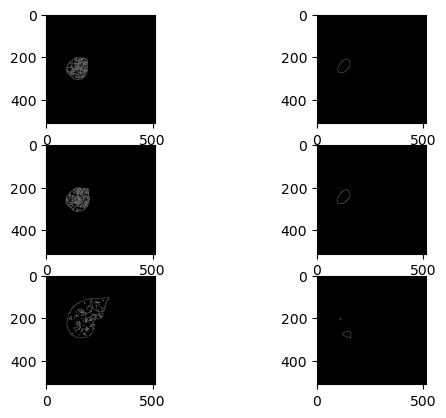

In [3]:
# 在原图以及gt上使用边缘检测算法提取出轮廓
gt_edge_1 = cv2.Canny(tumor_mask_1, 100, 200)
gt_edge_2 = cv2.Canny(tumor_mask_2, 100, 200)
gt_edge_3 = cv2.Canny(tumor_mask_3, 100, 200)
plt.subplot(3, 1, 1)
plt.imshow(gt_edge_1, cmap='gray')
plt.subplot(3, 1, 2)
plt.imshow(gt_edge_2, cmap='gray')
plt.subplot(3, 1, 3)
plt.imshow(gt_edge_3, cmap='gray')


In [4]:
# 尝试计算gt_edge的path signature
print(Counter(gt_edge_1.flatten()))  # 统计图像中一共有几种值，每个值分别有多少像素
edge_index_1=np.nonzero(gt_edge_1)  # 找到所有非零值，由于gt只有0和255，所以这里是找到所有255的像素，也是病灶边缘
print(Counter(gt_edge_2.flatten()))  # 统计图像中一共有几种值，每个值分别有多少像素
edge_index_2=np.nonzero(gt_edge_2)  # 找到所有非零值，由于gt只有0和255，所以这里是找到所有255的像素，也是病灶边缘
print(Counter(gt_edge_3.flatten()))  # 统计图像中一共有几种值，每个值分别有多少像素
edge_index_3=np.nonzero(gt_edge_3)  # 找到所有非零值，由于gt只有0和255，所以这里是找到所有255的像素，也是病灶边缘
edge_x_1=edge_index_1[0]  # 病灶边缘横坐标
edge_y_1=edge_index_1[1]  # 病灶边缘纵坐标
edge_x_2=edge_index_2[0]  # 病灶边缘横坐标
edge_y_2=edge_index_2[1]  # 病灶边缘纵坐标
edge_x_3=edge_index_3[0]  # 病灶边缘横坐标
edge_y_3=edge_index_3[1]  # 病灶边缘纵坐标

Counter({0: 261938, 255: 206})
Counter({0: 261931, 255: 213})
Counter({0: 262008, 255: 136})


In [5]:
# 看看这206个像素点的path signature效果
path_1=[[edge_x_1[i],edge_y_1[i]] for i in range(len(edge_x_1))]
path_2=[[edge_x_2[i],edge_y_2[i]] for i in range(len(edge_x_2))]
path_3=[[edge_x_3[i],edge_y_3[i]] for i in range(len(edge_x_3))]
path_1=np.array(path_1)
path_2=np.array(path_2)
path_3=np.array(path_3)
# NOTE: 注意，signatory源码中有一行path = path.transpose(0, 1)  # (batch, stream, channel) to (stream, batch, channel)，因此需要改变path的shape才可以正常使用
# NOTE: signatory以torch.tensor作为输入，因此要把numpy转成tensor
# BUG: 为了配合apex库，我希望使用np.float16作为数据类型，但是CPU不支持半精度计算，此外path放到GPU上之后半精度仍然报错，目前还没找到根源
path_1=torch.from_numpy(np.expand_dims(path_1,0).astype(np.float32))
path_2=torch.from_numpy(np.expand_dims(path_2,0).astype(np.float32))
path_3=torch.from_numpy(np.expand_dims(path_3,0).astype(np.float32))
path_1.cuda()
path_2.cuda()
path_3.cuda()
print('path_1\'s device is {}.'.format(path_1.device))
print('path_2\'s device is {}.'.format(path_2.device))
print('path_3\'s device is {}.'.format(path_3.device))
# NOTE: 这里的两个path仍然在cpu上，转换成nn.Parameter类型才可
# BUG: 需要修改模板中的顺序，backward之后再搞dice吧，虽然看上去没有什么影响（detach之后二值化虽然改变了pred的结果，但是梯度传播需要的是系数，不是它本身），但是保险起见改一下
path_1 = torch.nn.Parameter(path_1)
path_2 = torch.nn.Parameter(path_2)
path_3 = torch.nn.Parameter(path_3)
path_1=path_1.cuda()
path_2=path_2.cuda()
path_3=path_3.cuda()
print('path_1\'s shape is {}.'.format(path_1.shape))
print('path_2\'s shape is {}.'.format(path_2.shape))
print('path_3\'s shape is {}.'.format(path_3.shape))
print('path_1\'s device is {}.'.format(path_1.device))
print('path_2\'s device is {}.'.format(path_2.device))
print('path_3\'s device is {}.'.format(path_3.device))
sig_1=signatory.signature(path_1,3)
sig_2=signatory.signature(path_2,3)
sig_3=signatory.signature(path_3,3)
print('path_signature_1\'s shape is {}.'.format(sig_1.shape))
print('path_signature_2\'s shape is {}.'.format(sig_2.shape))
print('path_signature_3\'s shape is {}.'.format(sig_3.shape))
print(sig_1)
print(sig_2)
print(sig_3)

path_1's device is cpu.
path_2's device is cpu.
path_3's device is cpu.
path_1's shape is torch.Size([1, 206, 2]).
path_2's shape is torch.Size([1, 213, 2]).
path_3's shape is torch.Size([1, 136, 2]).
path_1's device is cuda:0.
path_2's device is cuda:0.
path_3's device is cuda:0.
path_signature_1's shape is torch.Size([1, 14]).
path_signature_2's shape is torch.Size([1, 14]).
path_signature_3's shape is torch.Size([1, 14]).
tensor([[ 6.4000e+01, -1.3000e+01,  2.0480e+03, -3.7800e+02, -4.5400e+02,
          8.4500e+01,  4.3691e+04, -3.7310e+03, -1.6730e+04,  7.4055e+03,
         -6.1630e+03, -9.8970e+03,  7.8995e+03, -3.6618e+02]], device='cuda:0',
       grad_fn=<_SignatureCombineFunctionBackward>)
tensor([[ 6.6000e+01, -1.5000e+01,  2.1780e+03, -4.1850e+02, -5.7150e+02,
          1.1250e+02,  4.7916e+04, -4.7225e+03, -1.8176e+04,  8.2805e+03,
         -9.7715e+03, -1.0283e+04,  9.4280e+03, -5.6251e+02]], device='cuda:0',
       grad_fn=<_SignatureCombineFunctionBackward>)
tensor([[9.

In [6]:
# 将两个gt_edge叠起来画出来看一下效果
fusion_gt_edge=np.dstack((gt_edge_1,gt_edge_3,gt_edge_2))
cv2.imwrite('./test.png',fusion_gt_edge,[int(cv2.IMWRITE_PNG_COMPRESSION),0])

True

In [7]:
# 计算两个path signature的余弦相似度
vec1=sig_1.flatten()
vec2=sig_2.flatten()
vec3=sig_3.flatten()
cosine_sim_1=(sig_1*sig_2).sum()
cosine_sim_1/=(sig_1.norm(2)*sig_2.norm(2))
print(cosine_sim_1)
cosine_sim_2=(sig_1*sig_3).sum()
cosine_sim_2/=(sig_1.norm(2)*sig_3.norm(2))
print(cosine_sim_2)

tensor(0.9983, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4724, device='cuda:0', grad_fn=<DivBackward0>)


In [8]:
# TODO: 超分辨率分成两个阶段，第一阶段从小放大关注shape（PS不具备sift-invariance因此要找另一个东西来做），第二阶段关注小病灶和大病灶的纹理相同
# TODO: contour寻找质心，将离得近的pred的质心和mask的质心作为一对，计算path_signature
# TODO: shape特征上的scale-invariant,超分辨率第一阶段从小到大靠shape特征，第二阶段从假到真靠color和texture特征

In [ ]:
# shape特征上的scale-invariant,超分辨率第一阶段从小到大靠shape特征，第二阶段从假到真靠color和texture特征
# 测试ps是否与大小无关
r_1 = 2.0  # 圆半径，修改这个值得大小调整圆圈的大小
r_2 = 1.0
a, b = (0., 0.)  # 圆心坐标，这个可以改变圆圈在的地方
Circle = np.arange(0, 2 * np.pi, 0.01)  # 参数方程
x_1 = a + r_1 * np.cos(Circle)
y_1 = b + r_1 * np.sin(Circle)
x_2 = a + r_2 * np.cos(Circle)
y_2 = b + r_2 * np.sin(Circle)
x_3 = x_1
y_3 = y_1 / 2.0
plt.plot(x_1, y_1)
plt.plot(x_2, y_2)
plt.plot(x_3, y_3)
plt.show()
path1 = [[x_1[i], y_1[i]] for i in range(len(x_1))]
path2 = [[x_2[i], y_2[i]] for i in range(len(x_2))]
path3 = [[x_3[i], y_3[i]] for i in range(len(x_3))]
path1 = np.array(path1)
path2 = np.array(path2)
path3 = np.array(path3)
path1 = torch.from_numpy(np.expand_dims(path1, 0).astype(np.float32))
path2 = torch.from_numpy(np.expand_dims(path2, 0).astype(np.float32))
path3 = torch.from_numpy(np.expand_dims(path3, 0).astype(np.float32))
sig1 = signatory.signature(path1, 5)
sig2 = signatory.signature(path2, 5)
sig3 = signatory.signature(path3, 5)
vec1 = sig1.flatten()
vec2 = sig2.flatten()
vec3 = sig3.flatten()
cosine_sim_1 = (sig1 * sig2).sum()
cosine_sim_1 /= (sig1.norm(2) * sig2.norm(2))
cosine_sim_2 = (sig1 * sig3).sum()
cosine_sim_2 /= (sig1.norm(2) * sig3.norm(2))
cosine_sim_3 = (sig3 * sig2).sum()
cosine_sim_3 /= (sig3.norm(2) * sig2.norm(2))
print(sig1)
print(sig2)
print(sig3)
print(cosine_sim_1)
print(cosine_sim_2)
print(cosine_sim_3)
print(sig1==sig2)

In [ ]:
import torch
import cv2
import numpy as np
from torch.autograd import gradcheck
from model.SINet_V2 import Network
from utils.utils import get_config
from torch.autograd.function import Function


test_input = torch.randn((2, 3, 64, 64), requires_grad=True, dtype=torch.float64).cuda(3)
test = torch.autograd.gradcheck(torch.sigmoid, test_input, eps=1e-3)
print(test)
